In [3]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.autograd import grad

from sklearn import linear_model, model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [4]:
# Load dataset 1

"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [5]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label


In [6]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [7]:
# Relearn Time 
def training_step(model, batch):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer.step()
    return loss.item()  

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0) * 100

def relearn_time(model, train_loader, valid_loader, reqAcc, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()  # Define your criterion here
    epochs = 0
    valid_accuracy = 0.0  # Initialize valid_accuracy
    while valid_accuracy < reqAcc:
        epochs += 1
        train_loss = 0.0
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate every epoch
        model.eval()
        valid_corrects = 0
        total = 0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                valid_corrects += torch.sum(preds == labels).item()
                total += labels.size(0)

        valid_accuracy = (valid_corrects / total) * 100

    return epochs
    
# Function to get predictions and true labels
@torch.no_grad()
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cuda()
            labels = labels.cuda()
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


#HTER CAlculation
def calculate_hter(y_true, y_pred):
    fpr, fnr = calculate_fpr_fnr(y_true, y_pred)
    hter = 0.5 * (fpr + fnr)
    return hter

def calculate_fpr_fnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    fpr = []
    fnr = []

    for i in range(num_classes):
        tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        fp = np.sum(cm[:, i]) - cm[i, i]
        fn = np.sum(cm[i, :]) - cm[i, i]
        tp = cm[i, i]

        fpr.append(fp / (fp + tn))
        fnr.append(fn / (fn + tp))

    return np.mean(fpr), np.mean(fnr)

# # Js-divergence and ZRF score
# def calculate_js_divergence(p, q):
#     # Calculate JS divergence between distributions p and q
#     m = 0.5 * (p + q)
#     js_divergence = 0.5 * (entropy(p, m) + entropy(q, m))
#     return js_divergence

# def calculate_zrf_score(original_model, retrained_model, test_dataloader):
#     # Pseudo-code to calculate ZRF score
#     original_preds = original_model.predict(test_dataloader)
#     retrained_preds = retrained_model.predict(test_dataloader)
    
#     zrf_score = 0.5 * (accuracy(original_preds, test_labels) + accuracy(retrained_preds, test_labels))
#     return zrf_score

In [8]:
from torch.autograd import grad

from sklearn.metrics import confusion_matrix
# Define the JS Divergence calculation function
def JSDiv(p, q):
    m = 0.5 * (p + q)
    p = p + 1e-10  # Adding a small epsilon to avoid log(0)
    q = q + 1e-10
    m = m + 1e-10
    return 0.5 * F.kl_div(torch.log(p), m, reduction='batchmean') + 0.5 * F.kl_div(torch.log(q), m, reduction='batchmean')
    
#This provides a normalized score, which is often useful for comparing different batches or datasets. 
#If you prefer to sum over the batch instead, you can change this to reduction='sum'

# Define the unlearning score calculation function
def compute_ZRF_JS_score(unlearned_model, original_model, forget_dataloader, device):
    def ZRFScore(tmodel, gold_model, forget_dl, device):
        model_preds = []
        gold_model_preds = []
        with torch.no_grad():
            for batch in forget_dl:
                x, _ = batch
                x = x.to(device)
                model_output = tmodel(x)
                gold_model_output = gold_model(x)
                model_preds.append(F.softmax(model_output, dim=1).detach().cpu())
                gold_model_preds.append(F.softmax(gold_model_output, dim=1).detach().cpu())
        
        model_preds = torch.cat(model_preds, axis=0)
        gold_model_preds = torch.cat(gold_model_preds, axis=0)
        return 1 - JSDiv(model_preds, gold_model_preds)
    
    # Compute JS Divergence
    js_div_score = 1 - ZRFScore(original_model, unlearned_model, forget_dataloader, device)
    
    # Compute ZRF Score using JS divergence
    zrf_score = ZRFScore(original_model, unlearned_model, forget_dataloader, device)
    
    return {'JS_Divergence': js_div_score.item(), 'ZRF_Score': zrf_score.item()}
    
# # Calculate FPR and FNR
# def fpr_fnr(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     fpr = fp / (fp + tn)
#     fnr = fn / (fn + tp)
#     return fpr, fnr

# Calculate per-example epsilon
def calculate_per_example_epsilon(FPR_list, FNR_list, delta=1e-5):
    per_example_epsilons = []
    
    for FPR, FNR in zip(FPR_list, FNR_list):
        if FPR == 0 and FNR == 0:
            per_example_epsilons.append(np.inf)
        elif FPR == 0 or FNR == 0:
            continue  # Discard attack if exactly one of FPR or FNR is 0
        else:
            epsilon1 = np.log(1 - delta - FPR) - np.log(FNR)
            epsilon2 = np.log(1 - delta - FNR) - np.log(FPR)
            per_example_epsilons.append(np.nanmax([epsilon1, epsilon2]))
    
    epsilon = np.nanmax(per_example_epsilons) if per_example_epsilons else 0
    return epsilon

def calculate_H(epsilon, bin_width=0.5, max_epsilon=6.5):
    bin_index = min(int(epsilon / bin_width), int(max_epsilon / bin_width))
    H_value = 2 / (2 ** bin_index)
    return H_value

def calculate_F(H_values):
    return np.mean(H_values)

def calculate_final_score(F_value, RA_U, RA_R, TA_U, TA_R):
    return F_value * (RA_U / RA_R) * (TA_U / TA_R)

def compute_forgetting_score(FPR_list, FNR_list, RA_U, RA_R, TA_U, TA_R, delta=1e-5, bin_width=0.5, max_epsilon=6.5):
    epsilon_values = [calculate_per_example_epsilon(FPR_list, FNR_list, delta)]
    H_values = [calculate_H(epsilon, bin_width, max_epsilon) for epsilon in epsilon_values]
    F_value = calculate_F(H_values)
    final_score = calculate_final_score(F_value, RA_U, RA_R, TA_U, TA_R)

    result = {
        'Epsilon Values': epsilon_values,
        'H Values': H_values,
        'F Value': F_value,
        'RA^U': RA_U,
        'RA^R': RA_R,
        'TA^U': TA_U,
        'TA^R': TA_R,
        'Forgeting Quality': final_score
    }
    
    # Print each key-value pair on a separate line
    for key, value in result.items():
        print(f"{key}: {value}")
    
    return result

# Function to calculate accuracy using your existing evaluation method
def cal_acc(model, dataloader):
    evaluation_result = evaluation(model, dataloader)
    return evaluation_result['Acc']

#Function to get MIA metrics using your existing cal_mia method
def get_mia_metrics(model):
    mia = cal_mia(model)
    return mia['MIA'], mia['Forgeting Score']

def compute_influence_scores(model, dataloader, criterion):
    influence_scores = []
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Compute gradients
        grads = grad(loss, model.parameters(), create_graph=True)
        
        # Compute influence score (sum of squared gradients)
        influence_score = sum((g**2).sum() for g in grads).item()
        influence_scores.append(influence_score)
        
    return influence_scores


In [9]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset = Dataset(unseen_meta_data, unseen_image_directory, unseen_transform)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)

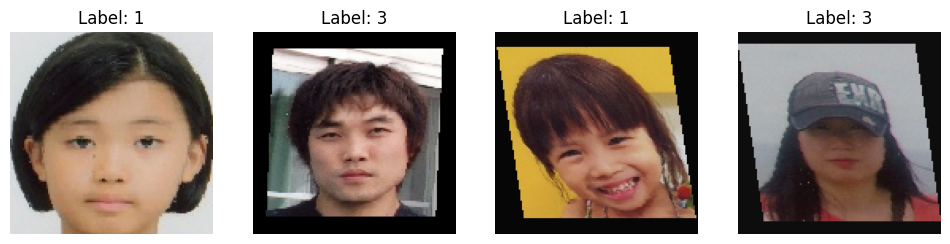

In [10]:
# Function to visualize a few samples from the dataloader
def visualize_samples(dataloader):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    # Plot a few images with their labels
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        ax = axes[i]
        img = images[i].numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

# Call the function with your dataloader
visualize_samples(train_dataloader)

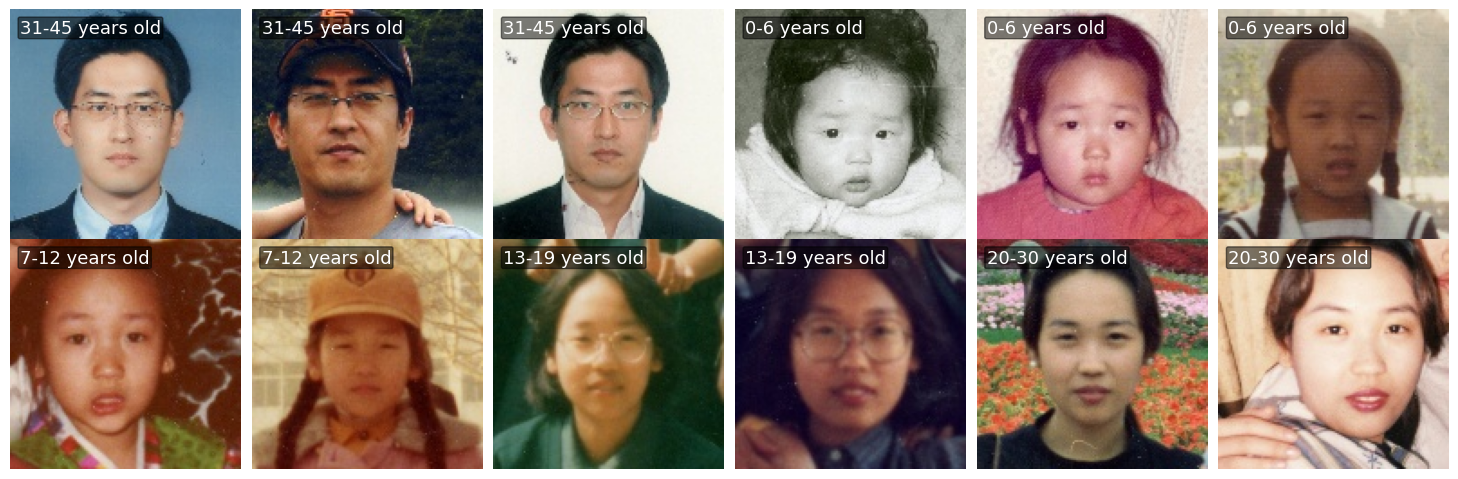

In [11]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [12]:
learning_rate = 0.01
log_step = 30

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.detach().cpu().numpy())

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item(), all_labels, all_preds

def test(dataloader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    for i, batch in enumerate(dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()
        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.detach().cpu().numpy())
        
        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')
    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item(), all_labels, all_preds


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_original_epochs = 30
best_test_acc = 0
best_epoch = 0

# Calculate and plot ROC and AUC for train, test, and unseen datasets
def plot_roc_curve(labels, preds, title):
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f})')

def plot_roc_auc_for_dataset(dataset_name, labels, preds):
    plt.figure(figsize=(10, 8))
    labels = np.array(labels)
    preds = np.array(preds)
    for i in range(8):
        plot_roc_curve((labels == i).astype(int), preds[:, i], f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
history = []
accuracy = []
for epoch in range(num_original_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc, train_labels, train_preds = train()
    test_loss, test_acc, test_labels, test_preds = test(test_dataloader)
    unseen_loss, unseen_acc, unseen_labels, unseen_preds = test(unseen_dataloader)
    history.append((train_loss, test_loss, unseen_loss))
    accuracy.append((train_acc, test_acc, unseen_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_original_epochs}.pth')

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.03211457381645839, running train accuracy: 0.18906250596046448
[Batch: 60] running train loss: 0.032217786212762195, running train accuracy: 0.20078125596046448
[Batch: 90] running train loss: 0.031485447825656994, running train accuracy: 0.21718750894069672
[Batch: 120] running train loss: 0.030728057383870085, running train accuracy: 0.2363281399011612
[Batch: 150] running train loss: 0.030091573012371857, running train accuracy: 0.2510416805744171
train loss: 0.03001022909644833, accuracy: 0.2553615868091583
elapsed time: 30.13784646987915
[Test]
[Batch: 1] running test loss: 0.02874244563281536, running test accuracy: 0.265625
test loss: 0.02908349656841831, accuracy: 0.31578946113586426
elapsed time: 1.9968256950378418
[Test]
[Batch: 1] running test loss: 0.02718718722462654, running test accuracy: 0.265625
test loss: 0.026671453914109695, accuracy: 0.34574466943740845
elapsed time: 2.219916820526123
[Info] best test accuracy

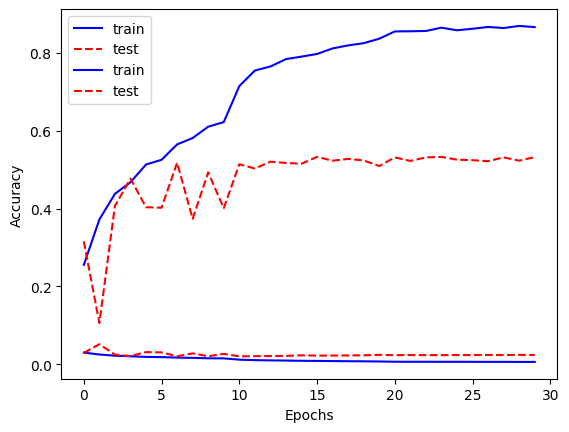

In [14]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

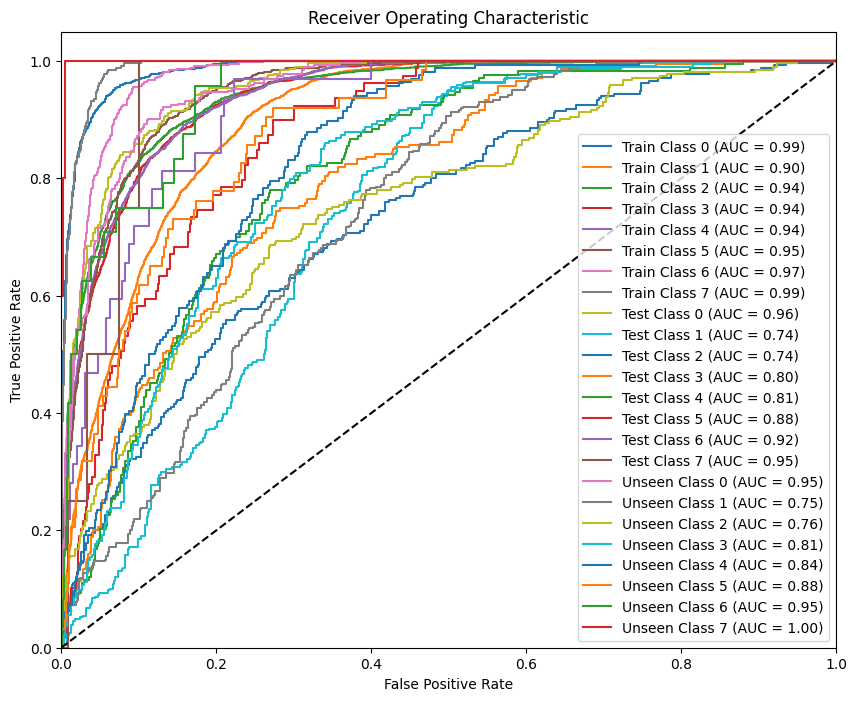

In [15]:
plt.figure(figsize=(10, 8))

# Train ROC and AUC
train_preds = np.array(train_preds)
train_labels = np.array(train_labels)
for i in range(8):
    plot_roc_curve((train_labels == i).astype(int), train_preds[:, i], f'Train Class {i}')

# Test ROC and AUC
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
for i in range(8):
    plot_roc_curve((test_labels == i).astype(int), test_preds[:, i], f'Test Class {i}')

# Unseen ROC and AUC
unseen_preds = np.array(unseen_preds)
unseen_labels = np.array(unseen_labels)
for i in range(8):
    plot_roc_curve((unseen_labels == i).astype(int), unseen_preds[:, i], f'Unseen Class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)
model = model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' 
# If you trian the original model from scratch.
model_path = f'pre_trained_last_checkpoint_epoch_30.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_acc, test_labels, test_preds = test(test_dataloader)
unseen_loss, unseen_acc, unseen_labels, unseen_preds = test(unseen_dataloader)
print("test loss:", test_loss, "test acc:", test_acc)
print("Unseen loss:", unseen_loss, "Unseen acc:", unseen_acc)

[Test]
[Batch: 1] running test loss: 0.02324518747627735, running test accuracy: 0.65625
test loss: 0.026781845472322183, accuracy: 0.5964912176132202
elapsed time: 1.7137033939361572
[Test]
[Batch: 1] running test loss: 0.019371023401618004, running test accuracy: 0.640625
test loss: 0.02154087853875566, accuracy: 0.65625
elapsed time: 1.685091257095337
test loss: 0.026781845472322183 test acc: 0.5964912176132202
Unseen loss: 0.02154087853875566 Unseen acc: 0.65625


In [17]:
forget_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_dataset_test, batch_size=64, shuffle=True)

retain_dataset_test = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_dataset_test, batch_size=64, shuffle=True)

In [18]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 1500
Retain dataset size: 8525
Unseen dataset size: 1504


In [19]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retain': 8525,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

In [20]:
#Performane Test
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 8)
original_model.load_state_dict(torch.load(original_save_path))
original_model = original_model.cuda()
criterion = nn.CrossEntropyLoss()

set_seed(42)

# Performance
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader)
mia = cal_mia(original_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.02324518747627735, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026781845472322183, accuracy: 0.5964912280701754, top-2 accuracy: 0.8804418453541261
elapsed time: 1.944819450378418
[Test]
[Batch: 1] running test loss: 0.019371023401618004, running test accuracy: 0.640625, running top-2 accuracy: 0.9375
test loss: 0.02154087853875566, accuracy: 0.65625, top-2 accuracy: 0.8936170212765957
elapsed time: 1.7188928127288818

Test Acc: {'Loss': 0.026781845472322183, 'Acc': 0.5964912280701754, 'Top-2 Acc': 0.8804418453541261}
Unseen Acc: {'Loss': 0.02154087853875566, 'Acc': 0.65625, 'Top-2 Acc': 0.8936170212765957}
MIA: {'MIA': 0.6797342192691032, 'Forgeting Score': 0.17973421926910316}
Final Score: 0.6185113947659846


In [21]:
# few things to build before starting the real work.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

influence_scores = compute_influence_scores(model, train_dataloader, criterion)

# Rank data points by influence scores
worst_case_indices = sorted(range(len(influence_scores)), key=lambda i: influence_scores[i], reverse=True)

# Select top k worst-case forget sets
k = 100  # Adjust as needed
worst_case_forget_set = [train_dataset[i] for i in worst_case_indices[:k]]

In [22]:
def train_model_using_only_retrain(model):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(retain_dataloader_train):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test_model(model):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
set_seed(42)

num_epochs = 30
best_test_acc = 0
best_epoch = 0
learning_rate = 0.01

retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 8)
retrained_model = retrained_model.cuda()
criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=learning_rate, momentum=0.9)

history = []
accuracy = []
# Start timing the unlearning process
start_time = time.time()
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train_model_using_only_retrain(retrained_model)
    test_loss, test_acc = test_model(retrained_model)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch

# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
print(f"Total unlearning time: {unlearning_time:.2f} seconds")

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.032242227780322236, running train accuracy: 0.18906250596046448
[Batch: 60] running train loss: 0.03165201048056285, running train accuracy: 0.21796876192092896
[Batch: 90] running train loss: 0.031223127390775415, running train accuracy: 0.23715278506278992
[Batch: 120] running train loss: 0.03083121810729305, running train accuracy: 0.24791668355464935
train loss: 0.03077194659940658, accuracy: 0.2521994113922119
elapsed time: 20.622745037078857
[Test]
[Batch: 1] running test loss: 0.03659192845225334, running test accuracy: 0.15625
test loss: 0.03272929278343354, accuracy: 0.235867440700531
elapsed time: 1.5823171138763428
[Info] best test accuracy!
[Epoch: 2 - Training]
[Batch: 30] running train loss: 0.0278793986265858, running train accuracy: 0.3187500238418579
[Batch: 60] running train loss: 0.027694803507377703, running train accuracy: 0.33281251788139343
[Batch: 90] running train loss: 0.026859655645158555, running train 

In [24]:
# Performance
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader)
mia = cal_mia(retrained_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print()
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.024843579158186913, running test accuracy: 0.484375, running top-2 accuracy: 0.78125
test loss: 0.023997042030386526, accuracy: 0.46848602988953864, top-2 accuracy: 0.7712800519818064
elapsed time: 1.472095012664795
[Test]
[Batch: 1] running test loss: 0.0217547919601202, running test accuracy: 0.5, running top-2 accuracy: 0.734375
test loss: 0.021586945914524668, accuracy: 0.5525265957446809, top-2 accuracy: 0.7972074468085106
elapsed time: 1.5079128742218018
Test Acc: {'Loss': 0.023997042030386526, 'Acc': 0.46848602988953864, 'Top-2 Acc': 0.7712800519818064}
Unseen Acc: {'Loss': 0.021586945914524668, 'Acc': 0.5525265957446809, 'Top-2 Acc': 0.7972074468085106}
MIA: {'MIA': 0.6661129568106313, 'Forgeting Score': 0.16611295681063132}

Final Score: 0.568130058134138


In [25]:
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
retrained_model = retrained_model.to(device)
model = model.to(device)
js_divergence = compute_ZRF_JS_score(retrained_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(retrained_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(retrained_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)

print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')

JS Divergence: 0.27328670024871826
ZRF Score: 0.7332702875137329
HTER: 0.08595239069344879


In [26]:
#Relearn time function
# reqAcc = 64
# lr = 0.001  
# retrained_model.to(device)
# rltime = relearn_time(retrained_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
# Evaluate the unlearned model
test_acc_o = cal_acc(model, test_dataloader)
retain_acc_o = cal_acc(model, retain_dataloader_train)
unseen_acc_o = cal_acc(model, unseen_dataloader)
mia_o, forgetting_score_o = get_mia_metrics(model)
# Evaluate the retain model
test_acc_retrained = cal_acc(retrained_model, test_dataloader)
retain_acc_retrained = cal_acc(retrained_model, retain_dataloader_train)
unseen_acc_retrained = cal_acc(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_o, labels_o = get_predictions(model, test_dataloader)
fpr_o, fnr_o = calculate_fpr_fnr(labels_o, preds_o)
FPR_list_o = [fpr_o]
FNR_list_o = [fnr_o]
# Compute forgetting score for unlearned model
results_o = compute_forgetting_score(FPR_list_o, FNR_list_o, retain_acc_o, retain_acc_retrained, test_acc_o, test_acc_retrained)
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
# evaluation_results_NG = evaluation(unlearnedNG_model, worst_case_forget_loader)
evaluation_results = evaluation(retrained_model, worst_case_forget_loader)

# print(f'Test Acc (Unlearned): {test_acc_unlearnedEWF}')
# print(f'Unseen Acc (Unlearned): {unseen_acc_unlearnedEWF}')
# print(f'MIA (Unlearned): {mia_unlearnedEWF}')
# print(f'Final Score (Unlearned): {(test_acc_unlearnedEWF + (1 - abs(mia_unlearnedEWF - 0.5) * 2)) / 2}')
print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')
print('*************************************************************************')
# print(f'Relearn time: {rltime} epochs')
print("MIA (Forget Quality): ", results_o)
print("MIA (Forget Quality): ", results_retrained)
print("Evaluation on worst-case forget set:", evaluation_results)

[Test]
[Batch: 1] running test loss: 0.02324518747627735, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026781845472322183, accuracy: 0.5964912280701754, top-2 accuracy: 0.8804418453541261
elapsed time: 1.8183197975158691
[Test]
[Batch: 1] running test loss: 0.0022220583632588387, running test accuracy: 0.953125, running top-2 accuracy: 1.0
[Batch: 30] running test loss: 0.0015276208277403688, running test accuracy: 0.96875, running top-2 accuracy: 0.9963541666666667
[Batch: 60] running test loss: 0.0014521844801492988, running test accuracy: 0.9682291666666667, running top-2 accuracy: 0.99609375
[Batch: 90] running test loss: 0.001349470614675536, running test accuracy: 0.9717013888888889, running top-2 accuracy: 0.9961805555555555
[Batch: 120] running test loss: 0.0013352100211098635, running test accuracy: 0.971484375, running top-2 accuracy: 0.9967447916666666
test loss: 0.0013407415984050969, accuracy: 0.9718475073313783, top-2 accuracy: 0.99648093841

In [27]:
#Experiment: Fine-tuning: paper
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(unlearned_model, test_dataloader)
print(test_acc)

set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

num_epochs = 2
# Start timing the unlearning process
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
# #Relearn time function
# reqAcc = 20
# lr = 0.001  
# unlearned_model.to(device)
# rltime = relearn_time(unlearned_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
# Evaluate the unlearned model
test_acc_unlearned = cal_acc(unlearned_model, test_dataloader)
retain_acc_unlearned = cal_acc(unlearned_model, retain_dataloader_train)
unseen_acc_unlearned = cal_acc(unlearned_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearned_model)
# Evaluate the retain model
test_acc_retrained = cal_acc(retrained_model, test_dataloader)
retain_acc_retrained = cal_acc(retrained_model, retain_dataloader_train)
unseen_acc_retrained = cal_acc(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearned_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]
# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unlearned_model = unlearned_model.to(device)
original_model = original_model.to(device)
js_divergence = compute_ZRF_JS_score(unlearned_model, original_model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearned_model, original_model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearned_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
# evaluation_results_NG = evaluation(unlearnedNG_model, worst_case_forget_loader)
evaluation_results = evaluation(unlearned_model, worst_case_forget_loader)

print(f'Test Acc (Unlearned): {test_acc_unlearned}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearned}')
print(f'MIA (Unlearned): {mia_unlearned}')
print(f'Final Score (Unlearned): {(test_acc_unlearned + (1 - abs(mia_unlearned - 0.5) * 2)) / 2}')
print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')
print('*************************************************************************')
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}') 
print(f"Total unlearning time: {unlearning_time:.2f} seconds")
# print(f'Relearn time: {rltime} epochs')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')
print("MIA (Forget Quality): ", results_unlearned)
# print("MIA (Forget Quality): ", results_retrained)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results)

[Test]
[Batch: 1] running test loss: 0.02324518747627735, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026781845472322183, accuracy: 0.5964912280701754, top-2 accuracy: 0.8804418453541261
elapsed time: 1.5987768173217773
{'Loss': 0.026781845472322183, 'Acc': 0.5964912280701754, 'Top-2 Acc': 0.8804418453541261}
Epoch [1/2], Batch [1/134] - Batch Loss: 0.0683
Epoch [1/2], Batch [2/134] - Batch Loss: 0.0693
Epoch [1/2], Batch [3/134] - Batch Loss: 0.1521
Epoch [1/2], Batch [4/134] - Batch Loss: 0.1001
Epoch [1/2], Batch [5/134] - Batch Loss: 0.1253
Epoch [1/2], Batch [6/134] - Batch Loss: 0.0667
Epoch [1/2], Batch [7/134] - Batch Loss: 0.1249
Epoch [1/2], Batch [8/134] - Batch Loss: 0.1276
Epoch [1/2], Batch [9/134] - Batch Loss: 0.1676
Epoch [1/2], Batch [10/134] - Batch Loss: 0.0694
Epoch [1/2], Batch [11/134] - Batch Loss: 0.0949
Epoch [1/2], Batch [12/134] - Batch Loss: 0.1774
Epoch [1/2], Batch [13/134] - Batch Loss: 0.0587
Epoch [1/2], Batch [14/134] -

In [ ]:
# Experiment: CwF

In [28]:
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearnedCwF_model = models.resnet18(pretrained=False)
num_features = unlearnedCwF_model.fc.in_features
unlearnedCwF_model.fc = nn.Linear(num_features, 8)
unlearnedCwF_model.load_state_dict(torch.load(original_save_path))
CwF_model = unlearnedCwF_model.cuda()
criterion = nn.CrossEntropyLoss()
# Print a weight set of a front layer in the network to check the freezing.
print(unlearnedCwF_model.layer1[0].conv1.weight[0][0])

set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, unlearnedCwF_model.parameters()), lr=0.001)

# Freeze all the parameters.
for param in unlearnedCwF_model.parameters():
    param.requires_grad = False

# Only unfreeze the last three layers for the fine-tuning.
for param in unlearnedCwF_model.layer3.parameters():
    param.requires_grad = True
for param in unlearnedCwF_model.layer4.parameters():
    param.requires_grad = True
for param in unlearnedCwF_model.avgpool.parameters():
    param.requires_grad = True
for param in unlearnedCwF_model.fc.parameters():
    param.requires_grad = True

num_epochs = 2
# Start timing the unlearning process
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearnedCwF_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")
    
# Performance
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
test_acc = evaluation(unlearnedCwF_model, test_dataloader)
unseen_acc = evaluation(unlearnedCwF_model, unseen_dataloader)
mia = cal_mia(unlearnedCwF_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")

tensor([[ 0.0823, -0.0807, -0.0291],
        [-0.0787, -0.8153, -0.2380],
        [ 0.0615, -0.1015, -0.0267]], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch [1/2], Batch [1/134] - Batch Loss: 0.0953
Epoch [1/2], Batch [2/134] - Batch Loss: 0.1448
Epoch [1/2], Batch [3/134] - Batch Loss: 0.1909
Epoch [1/2], Batch [4/134] - Batch Loss: 0.1118
Epoch [1/2], Batch [5/134] - Batch Loss: 0.0977
Epoch [1/2], Batch [6/134] - Batch Loss: 0.0906
Epoch [1/2], Batch [7/134] - Batch Loss: 0.1672
Epoch [1/2], Batch [8/134] - Batch Loss: 0.1456
Epoch [1/2], Batch [9/134] - Batch Loss: 0.1950
Epoch [1/2], Batch [10/134] - Batch Loss: 0.0871
Epoch [1/2], Batch [11/134] - Batch Loss: 0.1243
Epoch [1/2], Batch [12/134] - Batch Loss: 0.1584
Epoch [1/2], Batch [13/134] - Batch Loss: 0.1032
Epoch [1/2], Batch [14/134] - Batch Loss: 0.2185
Epoch [1/2], Batch [15/134] - Batch Loss: 0.0997
Epoch [1/2], Batch [16/134] - Batch Loss: 0.1709
Epoch [1/2], Batch [17/134] - Batch Loss: 0.1443
Epoch [1/2], 

In [29]:
# Performance
#Relearn time function
reqAcc = 20
lr = 0.001  
unlearnedCwF_model.to(device)
rltime_CwF = relearn_time(unlearnedCwF_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unlearnedCwF_model = unlearnedCwF_model.to(device)
model = model.to(device)
js_divergence_CwF = compute_ZRF_JS_score(unlearnedCwF_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score_CwF =  compute_ZRF_JS_score(unlearnedCwF_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedCwF_model, forget_dataloader_test)
hter_CwF = calculate_hter(y_true, y_pred)
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
evaluation_results_CwF = evaluation(unlearnedCwF_model, worst_case_forget_loader)

print(f'Relearn time: {rltime_CwF} epochs')
print(f'JS Divergence: {js_divergence_CwF}')
print(f'ZRF Score: {zrf_score_CwF}')
print(f'HTER: {hter_CwF}')
print("Evaluation on worst-case forget set:", evaluation_results_CwF)

[Test]
[Batch: 1] running test loss: 0.015947923064231873, running test accuracy: 0.71875, running top-2 accuracy: 0.859375
test loss: 0.01755694270133972, accuracy: 0.74, top-2 accuracy: 0.91
elapsed time: 0.06999921798706055
Relearn time: 1 epochs
JS Divergence: 0.9704722166061401
ZRF Score: 0.043118298053741455
HTER: 0.2626750242025391
Evaluation on worst-case forget set: {'Loss': 0.01755694270133972, 'Acc': 0.74, 'Top-2 Acc': 0.91}


In [30]:
#Performance
# Evaluate the unlearned model
test_acc_unlearnedCwF = cal_acc(unlearnedCwF_model, test_dataloader)
retain_acc_unlearnedCwF = cal_acc(unlearnedCwF_model, retain_dataloader_train)
unseen_acc_unlearnedCwF = cal_acc(unlearnedCwF_model, unseen_dataloader)
mia_unlearnedCwF, forgetting_score_unlearnedCwF = get_mia_metrics(unlearnedCwF_model)
# Evaluate the retain model
test_acc_retrained = cal_acc(retrained_model, test_dataloader)
retain_acc_retrained = cal_acc(retrained_model, retain_dataloader_train)
unseen_acc_retrained = cal_acc(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearnedCwF, labels_unlearnedCwF = get_predictions(unlearnedCwF_model, test_dataloader)
fpr_unlearnedCwF, fnr_unlearnedCwF = calculate_fpr_fnr(labels_unlearnedCwF, preds_unlearnedCwF)
FPR_list_unlearnedCwF = [fpr_unlearnedCwF]
FNR_list_unlearnedCwF = [fnr_unlearnedCwF]
# Compute forgetting score for unlearned model
results_unlearnedCwF = compute_forgetting_score(FPR_list_unlearnedCwF, FNR_list_unlearnedCwF, retain_acc_unlearnedCwF, retain_acc_retrained, test_acc_unlearnedCwF, test_acc_retrained)
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)

print(f'Test Acc (Unlearned): {test_acc_unlearnedCwF}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearnedCwF}')
print(f'MIA (Unlearned): {mia_unlearnedCwF}')
print(f'Final Score (Unlearned): {(test_acc_unlearnedCwF + (1 - abs(mia_unlearnedCwF - 0.5) * 2)) / 2}')
print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')
print('*************************************************************************')
print("MIA (Forget Quality) U: ", results_unlearnedCwF)
print("MIA (Forget Quality) R: ", results_retrained)


[Test]
[Batch: 1] running test loss: 0.03159656003117561, running test accuracy: 0.59375, running top-2 accuracy: 0.875
test loss: 0.03423489851948501, accuracy: 0.5497076023391813, top-2 accuracy: 0.8382066276803118
elapsed time: 1.8460659980773926
[Test]
[Batch: 1] running test loss: 0.028699534013867378, running test accuracy: 0.640625, running top-2 accuracy: 0.875
[Batch: 30] running test loss: 0.03184342694779237, running test accuracy: 0.5322916666666667, running top-2 accuracy: 0.85
[Batch: 60] running test loss: 0.03056529797613621, running test accuracy: 0.5515625, running top-2 accuracy: 0.8486979166666667
[Batch: 90] running test loss: 0.030525408188501992, running test accuracy: 0.5503472222222222, running top-2 accuracy: 0.8486111111111111
[Batch: 120] running test loss: 0.03008264216283957, running test accuracy: 0.5569010416666667, running top-2 accuracy: 0.851953125
test loss: 0.030238834266438863, accuracy: 0.5561290322580645, top-2 accuracy: 0.8526686217008798
elapse

In [ ]:
# Print a weight set of a front layer in the network to check the freezing.
print(unlearned_model.layer1[0].conv1.weight[0][0])

In [31]:
#EXPERIMENT: NegGrad
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearnedNG_model = models.resnet18(pretrained=False)
num_features = unlearnedNG_model.fc.in_features
unlearnedNG_model.fc = nn.Linear(num_features, 8)
unlearnedNG_model.load_state_dict(torch.load(original_save_path))
unlearnedNG_model = unlearnedNG_model.cuda()
criterion = nn.CrossEntropyLoss()

set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedNG_model.parameters(), lr=0.001)

dataloader_iterator = iter(forget_dataloader_train)

num_epochs = 2
# Start timing the unlearning process
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != x_retain.size(0):
            continue

        outputs_forget = unlearnedNG_model(x_forget.cuda())
        loss_ascent_forget = -criterion(outputs_forget, y_forget.cuda())

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()

        running_loss += loss_ascent_forget.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

# Performance
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
test_acc = evaluation(unlearnedNG_model, test_dataloader)
unseen_acc = evaluation(unlearnedNG_model, unseen_dataloader)
mia = cal_mia(unlearnedNG_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")

Epoch [1/2], Batch [1/134] - Batch Loss: -0.1444
Epoch [1/2], Batch [2/134] - Batch Loss: -0.1174
Epoch [1/2], Batch [3/134] - Batch Loss: -0.0995
Epoch [1/2], Batch [4/134] - Batch Loss: -0.2439
Epoch [1/2], Batch [5/134] - Batch Loss: -0.1847
Epoch [1/2], Batch [6/134] - Batch Loss: -0.0857
Epoch [1/2], Batch [7/134] - Batch Loss: -0.0472
Epoch [1/2], Batch [8/134] - Batch Loss: -0.0796
Epoch [1/2], Batch [9/134] - Batch Loss: -0.0431
Epoch [1/2], Batch [10/134] - Batch Loss: -0.0447
Epoch [1/2], Batch [11/134] - Batch Loss: -0.0970
Epoch [1/2], Batch [12/134] - Batch Loss: -0.1270
Epoch [1/2], Batch [13/134] - Batch Loss: -0.1929
Epoch [1/2], Batch [14/134] - Batch Loss: -0.0865
Epoch [1/2], Batch [15/134] - Batch Loss: -0.2027
Epoch [1/2], Batch [16/134] - Batch Loss: -0.0613
Epoch [1/2], Batch [17/134] - Batch Loss: -0.1751
Epoch [1/2], Batch [18/134] - Batch Loss: -0.2080
Epoch [1/2], Batch [19/134] - Batch Loss: -0.0551
Epoch [1/2], Batch [20/134] - Batch Loss: -0.0638
Epoch [1/

In [32]:
# Performance
#Relearn time function
reqAcc = 20
lr = 0.001  
unlearnedNG_model.to(device)
rltime = relearn_time(unlearnedNG_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)


print(f'Relearn time: {rltime} epochs')


Relearn time: 1 epochs


In [33]:
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unlearnedNG_model = unlearnedNG_model.to(device)
model = model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedNG_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedNG_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedNG_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
evaluation_results = evaluation(unlearnedNG_model, worst_case_forget_loader)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results)

[Test]
[Batch: 1] running test loss: 0.021329442039132118, running test accuracy: 0.5, running top-2 accuracy: 0.75
test loss: 0.03293546199798584, accuracy: 0.44, top-2 accuracy: 0.7
elapsed time: 0.06000542640686035
JS Divergence: 1.7586352825164795
ZRF Score: -0.7740439176559448
HTER: 0.3577143949159923
Evaluation on worst-case forget set: {'Loss': 0.03293546199798584, 'Acc': 0.44, 'Top-2 Acc': 0.7}


In [34]:
# Performance
# Evaluate the unlearned model
test_acc_unlearned = cal_acc(unlearnedNG_model, test_dataloader)
retain_acc_unlearned = cal_acc(unlearnedNG_model, retain_dataloader_train)
unseen_acc_unlearned = cal_acc(unlearnedNG_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearnedNG_model)
# Evaluate the retain model
test_acc_retrained = cal_acc(retrained_model, test_dataloader)
retain_acc_retrained = cal_acc(retrained_model, retain_dataloader_train)
unseen_acc_retrained = cal_acc(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearnedNG_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]
# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)


print(f'Test Acc (Unlearned): {test_acc_unlearned}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearned}')
print(f'MIA (Unlearned): {mia_unlearned}')
print(f'Final Score (Unlearned): {(test_acc_unlearned + (1 - abs(mia_unlearned - 0.5) * 2)) / 2}')
print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')
print('*************************************************************************')
print(f'Relearn time: {rltime} epochs')
print("MIA (Forget Quality) U: ", results_unlearned)
print("MIA (Forget Quality) R: ", results_retrained)


[Test]
[Batch: 1] running test loss: 0.048384085297584534, running test accuracy: 0.296875, running top-2 accuracy: 0.46875
test loss: 0.04389298729032104, accuracy: 0.31513970110461337, top-2 accuracy: 0.5224171539961013
elapsed time: 1.8803002834320068
[Test]
[Batch: 1] running test loss: 0.045425303280353546, running test accuracy: 0.265625, running top-2 accuracy: 0.5
[Batch: 30] running test loss: 0.036026988675196964, running test accuracy: 0.3338541666666667, running top-2 accuracy: 0.5875
[Batch: 60] running test loss: 0.03701500774671634, running test accuracy: 0.32473958333333336, running top-2 accuracy: 0.5705729166666667
[Batch: 90] running test loss: 0.03698367008732425, running test accuracy: 0.3329861111111111, running top-2 accuracy: 0.5755208333333334
[Batch: 120] running test loss: 0.03730460686298708, running test accuracy: 0.3321614583333333, running top-2 accuracy: 0.5723958333333333
test loss: 0.03754626686621971, accuracy: 0.3313782991202346, top-2 accuracy: 0.57

In [35]:
# Experiment with Joint Loss
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearnedJL_model = models.resnet18(pretrained=False)
num_features = unlearnedJL_model.fc.in_features
unlearnedJL_model.fc = nn.Linear(num_features, 8)
unlearnedJL_model.load_state_dict(torch.load(original_save_path))
unlearnedJL_model = unlearnedJL_model.cuda()
criterion = nn.CrossEntropyLoss()

set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedJL_model.parameters(), lr=0.001)

dataloader_iterator = iter(forget_dataloader_train)

num_epochs = 2

# Start timing the unlearning process
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != x_retain.size(0):
            continue

        outputs_retain = unlearnedJL_model(x_retain.cuda())
        outputs_forget = unlearnedJL_model(x_forget.cuda())

        loss_ascent_forget = -criterion(outputs_forget, y_forget.cuda())
        loss_retain = criterion(outputs_retain, y_retain.cuda())

        # Overall loss
        joint_loss = loss_ascent_forget + loss_retain

        print("joint loss :", joint_loss.item())
        optimizer.zero_grad()
        joint_loss.backward()
        optimizer.step()

        running_loss += joint_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {joint_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")


# Performance
test_acc = evaluation(unlearnedJL_model, test_dataloader)
unseen_acc = evaluation(unlearnedJL_model, unseen_dataloader)
# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
mia = cal_mia(unlearnedNG_model.cuda())

print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f"Total unlearning time: {unlearning_time:.2f} seconds")
print(f'MIA: {mia}')


joint loss : -0.013134658336639404
Epoch [1/2], Batch [1/134] - Batch Loss: -0.0131
joint loss : -0.013849250972270966
Epoch [1/2], Batch [2/134] - Batch Loss: -0.0138
joint loss : -0.05419261381030083
Epoch [1/2], Batch [3/134] - Batch Loss: -0.0542
joint loss : -0.14189277589321136
Epoch [1/2], Batch [4/134] - Batch Loss: -0.1419
joint loss : -0.0026763826608657837
Epoch [1/2], Batch [5/134] - Batch Loss: -0.0027
joint loss : 0.14550206065177917
Epoch [1/2], Batch [6/134] - Batch Loss: 0.1455
joint loss : 0.07922588288784027
Epoch [1/2], Batch [7/134] - Batch Loss: 0.0792
joint loss : -0.034462202340364456
Epoch [1/2], Batch [8/134] - Batch Loss: -0.0345
joint loss : 0.07800082862377167
Epoch [1/2], Batch [9/134] - Batch Loss: 0.0780
joint loss : 0.07604953646659851
Epoch [1/2], Batch [10/134] - Batch Loss: 0.0760
joint loss : 0.01553276926279068
Epoch [1/2], Batch [11/134] - Batch Loss: 0.0155
joint loss : 0.017269819974899292
Epoch [1/2], Batch [12/134] - Batch Loss: 0.0173
joint l

In [36]:
# Evaluate the unlearned model
test_acc_unlearned = cal_acc(unlearnedJL_model, test_dataloader)
retain_acc_unlearned = cal_acc(unlearnedJL_model, retain_dataloader_train)
unseen_acc_unlearned = cal_acc(unlearnedJL_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearnedJL_model)
# Evaluate the retain model
test_acc_retrained = cal_acc(retrained_model, test_dataloader)
retain_acc_retrained = cal_acc(retrained_model, retain_dataloader_train)
unseen_acc_retrained = cal_acc(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearnedJL_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]
# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unlearnedJL_model = unlearnedJL_model.to(device)
model = model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedJL_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedJL_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedJL_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
evaluation_results = evaluation(unlearnedJL_model, worst_case_forget_loader)

print(f'Test Acc (Unlearned): {test_acc_unlearned}')
print(f'Unseen Acc (Unlearned): {unseen_acc_unlearned}')
print(f'MIA (Unlearned): {mia_unlearned}')
print(f'Final Score (Unlearned): {(test_acc_unlearned + (1 - abs(mia_unlearned - 0.5) * 2)) / 2}')
print(f'Test Acc (Retained): {test_acc_retrained}')
print(f'Unseen Acc (Retained): {unseen_acc_retrained}')
print(f'MIA (Retained): {mia_retrained}')
print(f'Final Score (Retained): {(test_acc_retrained + (1 - abs(mia_retrained - 0.5) * 2)) / 2}')
print('*************************************************************************')

print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')
print("MIA (Forget Quality): ", results_unlearned)
# print("MIA (Forget Quality): ", results_retrained)
print(f'JS Divergence: {js_divergence}')
print(f'ZRF Score: {zrf_score}')
print(f'HTER: {hter}')
print("Evaluation on worst-case forget set:", evaluation_results)

[Test]
[Batch: 1] running test loss: 0.030931640416383743, running test accuracy: 0.5625, running top-2 accuracy: 0.84375
test loss: 0.041900472179336005, accuracy: 0.5633528265107213, top-2 accuracy: 0.8557504873294347
elapsed time: 1.6918609142303467
[Test]
[Batch: 1] running test loss: 0.006804484874010086, running test accuracy: 0.859375, running top-2 accuracy: 0.96875
[Batch: 30] running test loss: 0.006778823017763595, running test accuracy: 0.8755208333333333, running top-2 accuracy: 0.9677083333333333
[Batch: 60] running test loss: 0.0066594115147988004, running test accuracy: 0.8776041666666666, running top-2 accuracy: 0.9697916666666667
[Batch: 90] running test loss: 0.0067752532673896184, running test accuracy: 0.8765625, running top-2 accuracy: 0.9701388888888889
[Batch: 120] running test loss: 0.006857736786090148, running test accuracy: 0.875, running top-2 accuracy: 0.96953125
test loss: 0.00703596672092365, accuracy: 0.8724926686217008, top-2 accuracy: 0.96891495601173

In [37]:
#Relearn time function
reqAcc = 56
lr = 0.001  
unlearnedJL_model.to(device)
rltime = relearn_time(unlearnedJL_model, forget_dataloader_train, forget_dataloader_test, reqAcc, lr)
print(f'Relearn time: {rltime} epochs')

Relearn time: 2 epochs


In [38]:
# Experiment: Weight filtering
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

set_seed(42)

# Define the Weight Filtering Layer
class WeightFilteringLayer(nn.Module):
    def __init__(self, in_features, num_classes):
        super(WeightFilteringLayer, self).__init__()
        self.memory_vectors = nn.Parameter(torch.ones(num_classes, in_features))

    def forward(self, x, y_unl):
        memory_vector = self.memory_vectors[y_unl]
        return x * memory_vector

# Modify the ResNet18 model to include the WF layer
class ResNet18WithWF(nn.Module):
    def __init__(self, model, num_classes):
        super(ResNet18WithWF, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.wf_layer = WeightFilteringLayer(model.fc.in_features, num_classes)
        self.fc = nn.Linear(model.fc.in_features, num_classes)

    def forward(self, x, y_unl=1):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.wf_layer(x, y_unl)
        x = self.fc(x)
        return x

# Load the pre-trained model and modify it
model = models.resnet18(pretrained=True)
unlearnedWF_model = ResNet18WithWF(model, num_classes=8)

# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load(f'pre_trained_last_checkpoint_epoch_30.pth')

# Get the state dictionary of the modified model
unlearnedWF_model_state_dict = unlearnedWF_model.state_dict()

# Update the modified model state dictionary with the pre-trained model state dictionary
for name, param in pretrained_state_dict.items():
    if name in unlearnedWF_model_state_dict:
        unlearnedWF_model_state_dict[name] = param

# Load the updated state dictionary into the modified model
unlearnedWF_model.load_state_dict(unlearnedWF_model_state_dict)

# Move the model to GPU
unlearnedWF_model = unlearnedWF_model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedWF_model.parameters(), lr=0.001)

# Train the model with the weight filtering layer
num_epochs = 2
print_every = 20

# Start timing the unlearning process
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        y_unl = 1  # Specify the class to be forgotten
        outputs = unlearnedWF_model(imgs, y_unl)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")

# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
print(f"Total unlearning time: {unlearning_time:.2f} seconds")

# Evaluate the unlearned model
test_acc = evaluation(unlearnedWF_model, test_dataloader)
unseen_acc = evaluation(unlearnedWF_model, unseen_dataloader)
mia = cal_mia(unlearnedWF_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Using device: cuda
Epoch [1/2], Batch [20/134] - Batch Loss: 2.4969
Epoch [1/2], Batch [40/134] - Batch Loss: 1.9800
Epoch [1/2], Batch [60/134] - Batch Loss: 1.6770
Epoch [1/2], Batch [80/134] - Batch Loss: 1.3822
Epoch [1/2], Batch [100/134] - Batch Loss: 1.7517
Epoch [1/2], Batch [120/134] - Batch Loss: 1.6128
Epoch [1/2] - Average Loss: 1.9329
Epoch [2/2], Batch [20/134] - Batch Loss: 1.1701
Epoch [2/2], Batch [40/134] - Batch Loss: 1.3966
Epoch [2/2], Batch [60/134] - Batch Loss: 1.4816
Epoch [2/2], Batch [80/134] - Batch Loss: 1.4331
Epoch [2/2], Batch [100/134] - Batch Loss: 1.8525
Epoch [2/2], Batch [120/134] - Batch Loss: 1.5865
Epoch [2/2] - Average Loss: 1.5443
Total unlearning time: 38.31 seconds
[Test]
[Batch: 1] running test loss: 0.024912072345614433, running test accuracy: 0.421875, running top-2 accuracy: 0.703125
test loss: 0.02777424967854421, accuracy: 0.41325536062378165, top-2 accuracy: 0.6679662118258609
elapsed time: 1.3368232250213623
[Test]
[Batch: 1] running 

In [39]:
# Experiment: Weight filtering:
# Increase the Number of Epochs: Training for more epochs might improve accuracy as the model gets more time to learn from the data.
# Learning Rate Scheduler: Implementing a learning rate scheduler to reduce the learning rate over time can help fine-tune the model.
# Data Augmentation: Applying data augmentation techniques can help improve the model's generalization.
# Weight Decay: Adding weight decay (L2 regularization) to the optimizer can help prevent overfitting.
# Batch Normalization: Ensuring batch normalization layers are used can help stabilize and improve training.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

set_seed(42)

# Define the Weight Filtering Layer
class WeightFilteringLayer(nn.Module):
    def __init__(self, in_features, num_classes):
        super(WeightFilteringLayer, self).__init__()
        self.memory_vectors = nn.Parameter(torch.ones(num_classes, in_features))

    def forward(self, x, y_unl):
        memory_vector = self.memory_vectors[y_unl]
        return x * memory_vector

# Modify the ResNet18 model to include the WF layer
class ResNet18WithWF(nn.Module):
    def __init__(self, model, num_classes):
        super(ResNet18WithWF, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.wf_layer = WeightFilteringLayer(model.fc.in_features, num_classes)
        self.fc = nn.Linear(model.fc.in_features, num_classes)

    def forward(self, x, y_unl=1):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.wf_layer(x, y_unl)
        x = self.fc(x)
        return x

# Load the pre-trained model and modify it
model = models.resnet18(pretrained=True)
unlearnedWF_model = ResNet18WithWF(model, num_classes=8)

# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load(f'pre_trained_last_checkpoint_epoch_30.pth')

# Get the state dictionary of the modified model
unlearnedWF_model_state_dict = unlearnedWF_model.state_dict()

# Update the modified model state dictionary with the pre-trained model state dictionary
for name, param in pretrained_state_dict.items():
    if name in unlearnedWF_model_state_dict:
        unlearnedWF_model_state_dict[name] = param

# Load the updated state dictionary into the modified model
unlearnedWF_model.load_state_dict(unlearnedWF_model_state_dict)

# Move the model to GPU
unlearnedWF_model = unlearnedWF_model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearnedWF_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model with the weight filtering layer
num_epochs = 25
print_every = 20

# Start timing the unlearning process
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (imgs, labels) in enumerate(retain_dataloader_train):
        imgs = imgs.cuda()
        labels = labels.cuda()

        y_unl = 1  # Specify the class to be forgotten
        outputs = unlearnedWF_model(imgs, y_unl)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss.item():.4f}")

    average_epoch_loss = running_loss / len(retain_dataloader_train.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_epoch_loss:.4f}")
    scheduler.step()

# End timing the unlearning process
end_time = time.time()
unlearning_time = end_time - start_time
print(f"Total unlearning time: {unlearning_time:.2f} seconds")

# Evaluate the unlearned model
test_acc = evaluation(unlearnedWF_model, test_dataloader)
unseen_acc = evaluation(unlearnedWF_model, unseen_dataloader)
mia = cal_mia(unlearnedWF_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Using device: cuda
Epoch [1/25], Batch [20/134] - Batch Loss: 2.4993
Epoch [1/25], Batch [40/134] - Batch Loss: 1.9852
Epoch [1/25], Batch [60/134] - Batch Loss: 1.6774
Epoch [1/25], Batch [80/134] - Batch Loss: 1.3821
Epoch [1/25], Batch [100/134] - Batch Loss: 1.7529
Epoch [1/25], Batch [120/134] - Batch Loss: 1.6095
Epoch [1/25] - Average Loss: 1.9318
Epoch [2/25], Batch [20/134] - Batch Loss: 1.1685
Epoch [2/25], Batch [40/134] - Batch Loss: 1.3933
Epoch [2/25], Batch [60/134] - Batch Loss: 1.4707
Epoch [2/25], Batch [80/134] - Batch Loss: 1.4249
Epoch [2/25], Batch [100/134] - Batch Loss: 1.8473
Epoch [2/25], Batch [120/134] - Batch Loss: 1.6007
Epoch [2/25] - Average Loss: 1.5429
Epoch [3/25], Batch [20/134] - Batch Loss: 1.2611
Epoch [3/25], Batch [40/134] - Batch Loss: 1.3371
Epoch [3/25], Batch [60/134] - Batch Loss: 1.4507
Epoch [3/25], Batch [80/134] - Batch Loss: 1.5246
Epoch [3/25], Batch [100/134] - Batch Loss: 1.2904
Epoch [3/25], Batch [120/134] - Batch Loss: 1.2654
Epo

In [40]:
# Evaluate the unlearned model
test_acc_unlearned = cal_acc(unlearnedWF_model, test_dataloader)
retain_acc_unlearned = cal_acc(unlearnedWF_model, retain_dataloader_train)
unseen_acc_unlearned = cal_acc(unlearnedWF_model, unseen_dataloader)
mia_unlearned, forgetting_score_unlearned = get_mia_metrics(unlearnedWF_model)
# Evaluate the retain model
test_acc_retrained = cal_acc(retrained_model, test_dataloader)
retain_acc_retrained = cal_acc(retrained_model, retain_dataloader_train)
unseen_acc_retrained = cal_acc(retrained_model, unseen_dataloader)
mia_retrained, forgetting_score_retrained = get_mia_metrics(retrained_model)
# Calculate DP metrics for unlearned model
preds_unlearned, labels_unlearned = get_predictions(unlearnedWF_model, test_dataloader)
fpr_unlearned, fnr_unlearned = calculate_fpr_fnr(labels_unlearned, preds_unlearned)
FPR_list_unlearned = [fpr_unlearned]
FNR_list_unlearned = [fnr_unlearned]
# Compute forgetting score for unlearned model
results_unlearned = compute_forgetting_score(FPR_list_unlearned, FNR_list_unlearned, retain_acc_unlearned, retain_acc_retrained, test_acc_unlearned, test_acc_retrained)
# Calculate DP metrics for retrained model
preds_retrained, labels_retrained = get_predictions(retrained_model, test_dataloader)
fpr_retrained, fnr_retrained = calculate_fpr_fnr(labels_retrained, preds_retrained)
FPR_list_retrained = [fpr_retrained]
FNR_list_retrained = [fnr_retrained]
# Compute forgetting score for retrained model
results_retrained = compute_forgetting_score(FPR_list_retrained, FNR_list_retrained, retain_acc_retrained, retain_acc_retrained, test_acc_retrained, test_acc_retrained)
# Calculating JS divergence and ZRF score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unlearnedWF_model = unlearnedWF_model.to(device)
model = model.to(device)
js_divergence = compute_ZRF_JS_score(unlearnedWF_model, model, forget_dataloader_test, device)['JS_Divergence']
zrf_score =  compute_ZRF_JS_score(unlearnedWF_model, model, forget_dataloader_test, device)['ZRF_Score']
# Example of calculating HTER
y_true, y_pred = get_predictions(unlearnedWF_model, forget_dataloader_test)
hter = calculate_hter(y_true, y_pred)
# Evaluate your model on the worst-case forget set
worst_case_forget_loader = DataLoader(worst_case_forget_set, batch_size=64)
evaluation_results = evaluation(unlearnedWF_model, worst_case_forget_loader)

[Test]
[Batch: 1] running test loss: 0.01962743140757084, running test accuracy: 0.5625, running top-2 accuracy: 0.75
test loss: 0.02207401884771772, accuracy: 0.5042235217673814, top-2 accuracy: 0.7459389213775178
elapsed time: 1.722252368927002
[Test]
[Batch: 1] running test loss: 0.013634191825985909, running test accuracy: 0.671875, running top-2 accuracy: 0.875
[Batch: 30] running test loss: 0.015044456316779057, running test accuracy: 0.6192708333333333, running top-2 accuracy: 0.8322916666666667
[Batch: 60] running test loss: 0.014983098705609639, running test accuracy: 0.62265625, running top-2 accuracy: 0.8328125
[Batch: 90] running test loss: 0.015055735202299223, running test accuracy: 0.6232638888888888, running top-2 accuracy: 0.8335069444444444
[Batch: 120] running test loss: 0.014889774075709284, running test accuracy: 0.6248697916666667, running top-2 accuracy: 0.8373697916666667
test loss: 0.015010581065482758, accuracy: 0.6236950146627566, top-2 accuracy: 0.8356598240

RuntimeError: The size of tensor a (1000) must match the size of tensor b (8) at non-singleton dimension 1